### Predicting drug-taking
Why?

- The goal is to assess the causal effect of drug on cancer using a self-matching approach: I compare the cancer rate in the drug-taking population after treatment to the cancer rate before treatment. 
- However, we must control for the causal effect of cancer on a drug: in order to estimate this effect, I will compare the number of **first prescriptions** of a drug in the time after cancer to the number of first prescriptions **expected**  
    - "Expected" depends on age (ie, osteoporosis drugs) and year (ie, vioxx was discontinued in 2005)
    - Obviously other factors determine drug-taking but unless these are **systematically associated with onset of cancer**, such as a consequence of cancer, there is no reason these drugs should have a rate of first-prescription that is different in the time period after cancer.  

How? 
- A prescription is a tuple of $(drug, study\_week, age)$.  I **bin** prescription records into a given age, year, county, gender. We start by considering only one gender and one county.
- Then I estimate probability that any single first prescription in a bin $b$ will be for a given drug $d$, that is $p_{d,b}$
- Then, with this probability, we can evaluate the expectation over the cancer patients, over the time periods in question, and compare it to observed drug-taking

Below, we have one person's data, and how it falls into bins for every calendar year, and a bin for every 5 years of age. Each red triangle represents one first prescription of one drug for drugs A, R, C, etc.  

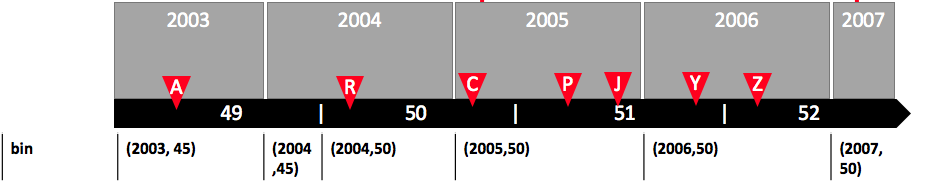

In [21]:
Image(filename='png/binning.png')

#### Considerations:
- If someone's first observed visit has a prescription, we don't know that this is a first prescription. It's just the first **observed** prescription.  Therefore, I require some "comparison" period per person. If this period is 2 years, then for the person above, we can say that drugs P, J, Y, Z are first prescriptions, but we don't know for drugs A, R, C because there is no comparison period.
- Some Rx are rarely repeating (ie, vaccines): therefore, I only use first-prescriptions.
- Some people have more Rx overall than others:  see below, for a small county, the distribution of number of first-Rx total, and number of first-Rx in a randomly selected one-year period for each person (x-axes are log-scaled)

#### Assumptions:
- The bin that a prescription falls into is the primary driver of an expected rate of drug. Thus we want to estimate $p_{d,b}$, the probability that a first-Rx that takes place in bin $b$ will be a prescription for drug $d$.
- Although by definition for each person, only one Rx can be an first-Rx, the more Rx you have, the more likely that one of these will be a first-Rx for drug $d$

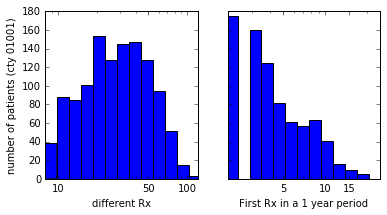

In [19]:
Image(filename='png/numvis.png')

### Approach 1: Modeling drug prescription as a conditional binomial
Given that a person has a total of $v$ Rx that take place in bin $b$, and given a bin-specific probability of prescription of $d$, $p_{d,b}$, we can model the number of Rx $k$ in bin $b$ for drug $d$ as a conditional (truncated) Binomial, that can only take on values of 0 or 1:
$$ k \sim { Binomial(k, v, p_{d,b}) \over \sum_{k' \in {0,1}} Binomial(k', v, p_{d,b}) } $$

From this, we can get probability of a first Rx of $d$ over all $v$ visits in bin $b$, $p(k_{d,b} = 1 | v, p_{d,b})$, which I label as $p_{d,b,v}$. This comes out to :
$$ p_{d,b,v} = {{v \cdot p_{d,b}}\over{v \cdot p_{d,b} - p_{d,b} + 1}} $$

Below, the relationship between $p_{d,b}$ (colored lines), $v$ (x-axis), and $p_{d,b,v}$ (y-axis)

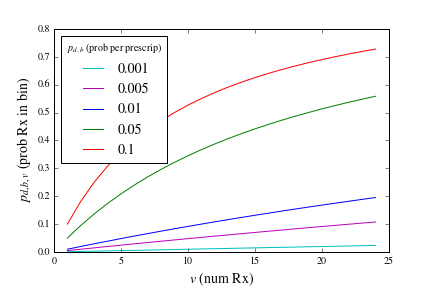

In [20]:
Image(filename='png/pdrugpvis.png')

If $X_{v,b}$ people are observed with $v$ first-Rxs in bin $b$, and $Y_{v,b}$ of those people have an Rx for drug $d$ in that bin, we can get the maximum likelihood estimate for drug $d$ for that bin: 
$$ {\hat{p}_{d,b,v}} = {Y_{v,b} \over X_{v,b}}$$

Then, we can estimate the bin-specific probability, accounting for number of visits. 
$$ \hat{p}_{d,b} = { {\hat{p}_{d,b,v}} \over { v + {\hat{p}_{d,b,v}} - {\hat{p}_{d,b,v}}\cdot v  } }$$ 

Getting the overall $\hat{p}_{d,b}$ involves maximizing the total likelihood with varying values of $v$. I have not yet figured out how to do this, but working on it.

Below, I show some estimated prescription rates per first prescription, $\hat{p}_{d,b}$, done incorrectly, because they do not account for the heterogeneity of the number of prescriptions per person.  But it gives you an idea. The rate of prescription of a given drug, per observed first-Rx, is shown as a function of year, age (with 95% binomial CI shaded), and both. Note that years 0 and 1 do not have an estimated rate because they can only be observed as a comparison period.  The 

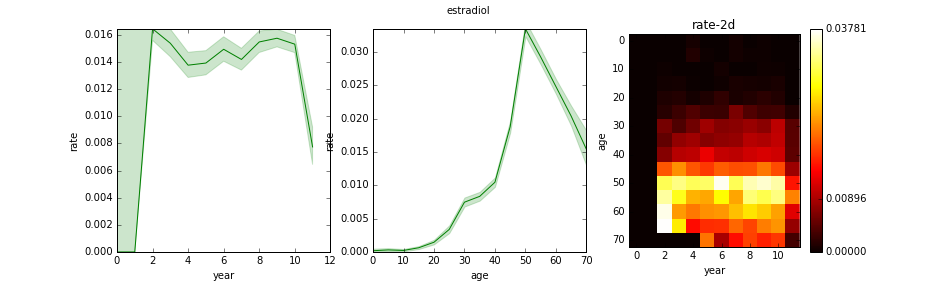

In [14]:
Image(filename='png/estradiol.png')

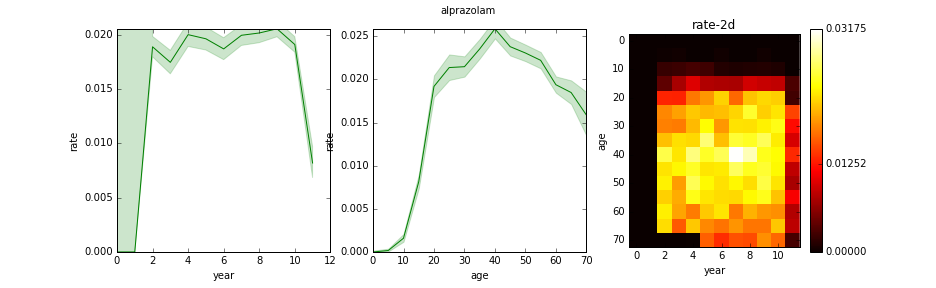

In [15]:
Image(filename='png/alprazolam.png')

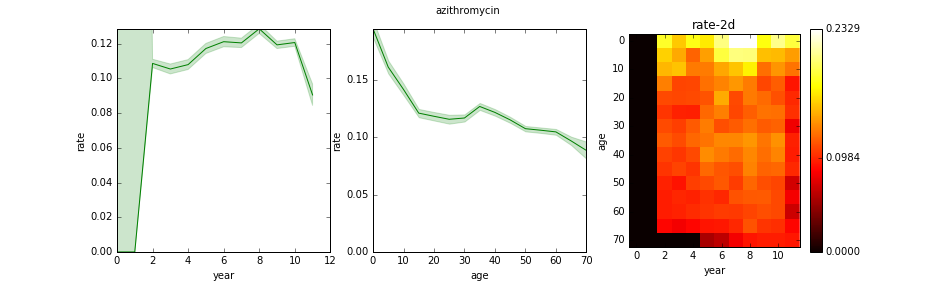

In [16]:
Image(filename='png/azithromycin.png')

#### Evaluating the expected and observed rate of prescription in post-cancer period under this model
Once I have $\hat{p}_{d,b}$ (which I can't do yet), I can evaluate expected and observed drug rate over all people with cancer, who are observed both before and after cancer.  (We require at least 2 years observed before cancer, and evaluate drug-taking over the $w$ years after cancer.)

Given a person $i$ who gets cancer at given time and age, define the post cancer period as window of time $w$ starting at the diagnosis of cancer. I obtain the set of first-Rx for that person in the post-cancer period. Each of these first-Rx fall into one or more bins. I obtain the time-ordered list of these bins, which each contain a set of first-RX $Rx_{i,b}$

For example, below, person $i$ got breast cancer in the beginning of 2005, when she was almost 51 years old. The window size = 2 years, so the post-cancer period is defined as all of 2005 and all of 2006. Two bins are observed.

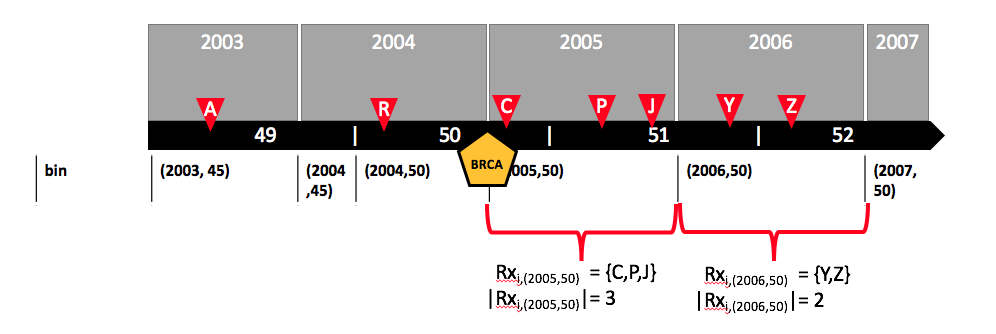

In [22]:
Image(filename='png/bineval.png')

Then, since we have $v = \left\vert{Rx_{i,b}}\right\vert = \left\vert{Rx_{i,(2005,50)}}\right\vert= 3$, and we have $\hat{p}_{d,b}$, we can get the probability of a first prescription in the first bin, using the formula above to get $\hat{p}_{d,b,v} = \hat{p}_{d,(2005,50),3}$

For the second bin, we must also calculate the probability that the first Rx did not fall in the first bin. So for the example, the probability of getting a first-Rx for drug $d$ in bin $(2006, 50)$, requires that she did not get the Rx in bin $(2005, 50)$, so it is: $$\hat{p}_{d,(2006,50),2} \cdot (1 - \hat{p}_{d,(2005,50),3})$$

Using the ordered list of bins for person $i$: $b_j = b_1 \dots b_i $ observed for the patient $i$, and defining $\hat{p}_{d,b_0,v} = 0 $, the expected number of Rx is: 
$$ E_{i,d} = \sum_{b_j = b_1}^{b_i} ({ \hat{p}_{d,b_j,\left\vert{Rx_{i,b}}\right\vert}  } \cdot \prod_{b_{j'} = b_0}^{b_{j-1}} 1 -  \hat{p}_{d,b_{j'},\left\vert{Rx_{i,b_{j'}}}\right\vert }) $$

The observed number of Rx for person $i$, for drug d, is simply
$$ O_{i,d} = \sum_{b_j = b_1}^{b_i} I(d \in Rx_{i,b_j} ) $$

We can just add these up over all people to get our causal effect of cancer on drug prescribing.

### Approach 2:  Modeling as a Poisson regression
As above, we do the same binning of prescriptions, and then partitioning people into sets with the same number of prescriptions $v$ per bin.  Here I represent a bin as binary vectors ($b_a, b_y$) , which indicate which year and which age is represented in the bin. Then I model number of first-prescriptions ($Y_{v,b}$) among the $X_{v,b}$ people with $v$ prescriptions in bin $b$:

$$ Y_{v,b} \sim X_{v,b} \cdot v \cdot exp(\sum_{f \in years} \sum_{g \in ages}\beta_{y,a} \cdot (b_{y,f}* b_{a,g}) + \sum_{f \in years} \beta_y \cdot  b_{y,f} + \sum_{g \in ages} \beta_a \cdot b_{a,g}  )$$

or for short:
$$ Y_{v,b} \sim X_{v,b} \cdot v \cdot exp(\lambda )$$

#### Evaluating expected/observed
Similar to above, but now we calculate $\hat{p}_{d,b,v}$ using the Poisson model.

In [2]:
from IPython.display import Image
